In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 20
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 5
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon-flyer. I have no idea how to fly. I just like to fly. I've seen my own shadow flying in the sky, but it's not me. I just want to fly. And I want to fly with you. I'm a dragonflyer. I want to be a dragonflyer. I want to fly with you.

But I have no idea how to fly. I just like to fly. I've seen my own shadow flying in the sky, but it's not me. I just want to fly. And I want to fly with you.


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


soon" now refers to a time span of over 2 hours when waiting for a scheduled appointment."<|endoftext|><p><msg>c "Who knows."<d><scn>office<msg>Sb "Now, let's take a look at what you've got for me."<d><scn>office<msg>Sb "The witness report from Anna is good. Nothing new to us, but it's nice to have her statement in writing."<d><scn>office<msg>Sb "What you've learned about the map is fascinating, if not a little unsettling. While it's good
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


>Lo "Now that we're here, I can tell you that no expense will be spared to make our portrayal of humans as accurate as possible."<|endoftext|><d><scn>loremapt<msg>Ip "Evidently, she thinks otherwise."<|endoftext|><p><msg>c "Fight Ipsum"<d><scn>loremapt<msg>m "Ipsum barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|><p><msg>c "You aren't planning on drinking it all at
 once, right?"<|endoftext|><d><scn>office<msg>m "When I arrived at the station, I was met by the police archivist, a dragoness who introduced herself as Kalinth."<p><msg>c "(Who's he talking to?)"<p><msg>c "(Oh, it's her again.)"<p><msg>c "(Hey, I think I've seen her before.)"<|endoftext|><d><scn>cafe<msg>Ad "Who's your companion?"<|endoftext|><d><scn>cafe<msg>An "Who is cited as one


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
21,4.028000
42,2.607700
63,2.031800
84,1.902700
105,1.825300
126,1.804100
147,1.796100
168,1.838400
189,1.842600
210,1.806600


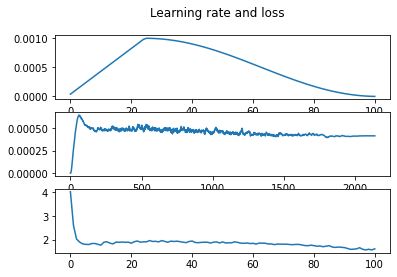

In [9]:
fig, axs = plt.subplots(3)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['model_closeness_loss'])
axs[2].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 1.17 MiB/s, done.
Using framework PyTorch: 1.10.1+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyTor

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        #!rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model.onnx"))

In [14]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragon. I can fly, I can attack, and I can even fly in the sky."<d><scn>loremapt<msg>Lo "[player_name], please read this carefully."<d></p><p><msg>c "[player_name], what are you?"<d><p><scn>msgv 'x<msg>c "I'm not sure, but I think I can handle this."<p><msg>c "[player_name], what are you?"<d><scn>msgx "I'm a dragon."<p><msg>c "[
PyTorch: In my dreams, I'm a dragon."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon. I can fly, I can attack, and I can even fly in the sky."<p></msg></p><p><msg>c "I see. I see."<d><?"><?"><|endoftext|>
PyTorch: In my dreams, I'm a dragon."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon. I can fly, I can attack, and I can even fly in the sky."<d><scn>black><?><?><scm<><???><?php><|endoftext|>
PyTorch: In my dreams, I'm a dragon."<d><scn>

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [15]:
test_regular_sampler()

In my dreams, I'm a dragon."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [16]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park


Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I think he's a good friend."<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."<p


Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Ad "I'm not sure, but I think I might be able to help."<p><msg>c "I'm not sure, but I think I might be able to help."<d><scn>black<msg>Ad "I'm not sure, but I think I might be able to help."<p><msg>c "I'm not sure, but I think


Prompt: What will we do here?
Reply: np1x<msg>Br "I don't know. I'm not sure I can."<d><scn>np1x<msg>Br "I'm not sure I can."<d><scn>np1x<msg>m "I sat down on a chair in Anna's lab."<d><scn>np1x<msg>Br "I don't know. I'm not sure I can


Test ONNX...
Prompt: How are you?
Reply

# Sampling test

This is gonna be interesting!

In [17]:
print("Test Pytorch...")
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
logging.basicConfig(level=logging.DEBUG)
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-" * 10)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "How are you?"<p><msg>c "Hey Remy, I know you wanted to talk about your work, but this is your chance to do it again."<d><scn>park2<msg>Ry "Good to hear that."<p><msg>c "You can't say that."<d><scn>park2<msg>Ry "I

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I don't think so."<p><msg>c "You know, I can help with this, if you don't mind."<d><scn>park2<msg>Ad "Well, that's a shame."<d><scn>park2<msg>Ad "I think I'll just go and have a

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: o2<msg>Ad "It's a toy."<d><scn>o2<msg>Ad "Well, I don't have any personal effects here, so it doesn't really matter."<p><msg>c "No, I'm not talking about my effects."<d><scn>o2<msg>Ad "You know what, I'll just get you some coffee and

[Test 1] -> Prompt: What will we do here?
Reply: loremapt<msg>Lo "I don't know. I just wanted to talk."<p><msg>c "Alright."<d><scn>loremapt<msg>Lo "The task is now given to y

# RP test
Testing out the injected roleplay actions

In [18]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'[Pytorch] {rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
    print(f'[ONNX] {rp} -> {onnx_model_manager.say("", rp, do_sample = True)}')
    print("-" * 10)

[Pytorch] Visit Lorem -> loremapt<msg>Lo "I don't think I've heard a soul in a while."<|endoftext|>
[ONNX] Visit Lorem -> loremapt<msg>Lo "Oh, [player_name]!"<|endoftext|>
----------
[Pytorch] Meet with Lorem -> loremapt<msg>Lo "Oh, and she also had a great time with you."<|endoftext|>
[ONNX] Meet with Lorem -> loremapt<msg>Lo "Oh, wow. That sounds like a really good idea."<d><scn>loremapt<msg>Lo "I think I'll just have to wait a few more seconds."<p><msg>c "Hey, Loremi."<d><scn>loremapt<msg>Lo "Hey."<p><msg>c "Hey, Loremi!"<d><scn>loremapt<msg>Lo "Hey, Loremi."<p><msg>c "Hey, Loremi."<d><scn>loremapt<
----------
[Pytorch] Visit Adine -> park2<msg>Adine "Hey [player_name]!"<|endoftext|>
[ONNX] Visit Adine -> office<msg>Adine "Oh?"<p><msg>c "I see."<d><scn>office<msg>Adine "Do I?"<p><msg>c "I see you're in charge of the project right now."<d><scn>office<msg>Adine "Oh, I see."<p><msg>c "I see..."<d><scn>office<msg>Adine "Oh? Are you okay, then?"<p><msg>c "I see."<d><scn>office<msg>Adine 